In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Feature Extraction

In [2]:
data_file= "/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [3]:
no_speakers_file = 40

def speakers_list(no_speakers_file, data_file):
    # Get all subfolders in the data_file directory, excluding parent or hidden folders
    subfolders = [f.name for f in os.scandir(data_file) if f.is_dir() and not f.name.startswith('50')]
    
    # Check if the requested number of speakers is available
    if no_speakers_file > len(subfolders):
        raise ValueError(f"Requested {no_speakers_file} speakers, but only {len(subfolders)} available.")
    
    # Select the first 'no_speakers_file' subfolders
    speaker_l = subfolders[:no_speakers_file]
    
    return speaker_l

# Example usage
# data_file should be the path to your main folder containing speaker folders
speaker_list = speakers_list(no_speakers_file, data_file)

In [4]:
speaker_list

['Speaker0043',
 'Speaker_0014',
 'Speaker0029',
 'Speaker0047',
 'Speaker_0009',
 'Speaker0039',
 'Speaker0041',
 'Speaker0026',
 'Speaker_0018',
 'Speaker_0016',
 'Speaker0045',
 'Speaker_0005',
 'Speaker_0010',
 'Speaker0027',
 'Speaker0034',
 'Speaker0037',
 'Speaker_0012',
 'Speaker0049',
 'Speaker_0008',
 'Speaker_0020',
 'Speaker_0021',
 'Speaker0046',
 'Speaker_0006',
 'Speaker0038',
 'Speaker0035',
 'Speaker0033',
 'Speaker_0003',
 'Speaker0032',
 'Speaker_0023',
 'Speaker0048',
 'Speaker_0001',
 'Speaker_0011',
 'Speaker_0007',
 'Speaker_0004',
 'Speaker0050',
 'Speaker_0013',
 'Speaker_0017',
 'Speaker0028',
 'Speaker0044',
 'Speaker0030']

In [5]:
def extract_mfcc(parent_dir, sub_folders, n_mfcc=13, max_pad_len=1600 , mfcc_window_len= 32):
    x = []
    y = []
    
    for label, folder in enumerate(sub_folders):
        folder_path = os.path.join(parent_dir, folder)
        
        # Loop through each audio file in the speaker's folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):  # Only process .wav files
                file_path = os.path.join(folder_path, file_name)
                
                audio, sr = librosa.load(file_path, sr=None)

                # Extract MFCC features
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                
                scaler = StandardScaler()
                mfcc = scaler.fit_transform(mfcc.T)
#                 mfcc.T

                # Padding or truncating the MFCC feature array
                if mfcc.shape[0] < max_pad_len:
                    pad_width = max_pad_len - mfcc.shape[0]
                    mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
                else:
                    mfcc = mfcc[:max_pad_len ,:]

                # Slice the MFCC into windows of window_len
                num_windows = mfcc.shape[0] // mfcc_window_len
                for i in range(num_windows):
                    start = i * mfcc_window_len
                    end = start + mfcc_window_len
                    mfcc_window = mfcc[start:end,: ]
                    x.append(mfcc_window)
                    y.append(label)
    
    x= np.array(x)
    y= np.array(y)
    return x,y

In [6]:
# x,y= extract_mfcc(data_file,speaker_list)

In [7]:
def find_missing_labels(x, y):
    labels_with_data = set(y)
    all_labels = set(range(no_speakers_file))  # Assume labels are 0 to len(sub_folders)-1
    missing_labels = all_labels - labels_with_data

    if missing_labels:
        print("Labels with no extracted MFCC data:", missing_labels)
        print("These labels likely correspond to folders with corrupted files.")
    else:
        print("All labels have extracted MFCC data.")

In [8]:
# find_missing_labels(x, y)

### Saving and Loding data

In [9]:
# os.remove("mfcc_data.npz")

In [10]:
# output_file = 'mfcc_data_40s.npz'
# np.savez_compressed(output_file, features=x, labels=y)

# print(f"Data saved to {output_file}.")

In [11]:
# Load the saved data
loaded_data = np.load('/kaggle/input/40-s-mfcc/mfcc_data_40s.npz')

# Access the features and labels
x = loaded_data['features']
y = loaded_data['labels']

print("Data loaded successfully.")
print(f"Features shape: {x.shape}")
print(f"Labels shape: {y.shape}")

Data loaded successfully.
Features shape: (98550, 32, 13)
Labels shape: (98550,)


In [12]:
x.shape , x[0][0]

((98550, 32, 13),
 array([-2.2259212 , -1.2796526 , -0.2796145 , -0.71824956, -0.29708213,
        -0.24781032,  0.70123214,  0.03300121,  0.91958654,  0.23709875,
         0.69457734,  0.2173065 ,  0.4055068 ], dtype=float32))

In [13]:
y.shape

(98550,)

## Testing parameters 

In [14]:
# test_file='/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data/Speaker_0004/Speaker_0004_00005.wav'
# audio, sr = audio, sr = librosa.load(test_file, sr=None)
# mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
# stand_s= StandardScaler()
# mfcc = stand_s.fit_transform(mfcc.T)

In [15]:
# (mfcc.shape), mfcc[0]

# Simple Model building

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Training Data Shape:", x_train.shape)
print("Test Data Shape:", x_test.shape)

Training Data Shape: (78840, 32, 13)
Test Data Shape: (19710, 32, 13)


In [17]:
x_train.shape

(78840, 32, 13)

In [18]:
input_shape=(32,13)

In [19]:
model = models.Sequential([
    layers.Input(input_shape),
    layers.Flatten(),
    layers.Dense(512 , activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),    
    layers.Dense(no_speakers_file, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,184 (1.37 MB)

 Trainable params: 356,648 (1.36 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if y_train is one-hot encoded
              metrics=['accuracy'])

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=20,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)

In [22]:
# history = model.fit(x_train, y_train, 
#                     validation_data=(x_test, y_test),
#                     epochs=100,  # Adjust the number of epochs as needed
#                     batch_size=128,
#                     callbacks=[early_stopping])

In [23]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# plot_training_history(history)

In [24]:
# from sklearn.metrics import classification_report

# y_pred_probs = model.predict(x_test)

# # Step 2: Convert probabilities to class labels
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Step 3: Generate and print the classification report
# print(classification_report(y_test, y_pred))

# Triplet loss implementation 

## Triplet generation

In [25]:
def generate_triplets(dataset, label, sample_per_class=30000):
  x, y = None, None
  for i in range(no_speakers_file):
    pos_indices = np.argwhere(label == i)[:, 0]
    neg_indices = np.argwhere(label != i)[:, 0]

    # Ensure there are positive and negative samples available
    if len(pos_indices) == 0 or len(neg_indices) == 0:
      print(f"Warning: Skipping class {i} due to lack of sufficient samples.")
      continue

    choice_anchor = np.random.choice(len(pos_indices), sample_per_class, replace=True)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(len(pos_indices), sample_per_class, replace=True)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(len(neg_indices), sample_per_class, replace=True)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    sub_x_pos = dataset[choice_pos]
    sub_x_neg = dataset[choice_neg]
        
    if x is None:
      x = [sub_x_anc, sub_x_pos, sub_x_neg]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], sub_x_anc))
      x[1] = np.vstack((x[1], sub_x_pos))
      x[2] = np.vstack((x[2], sub_x_neg))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y


In [26]:
# train_x, train_y = generate_triplets(x_train, y_train)

In [27]:
# len(train_x[0])
# 390000 x 32 x 13

## Creating Embedding Model


In [28]:
from tensorflow.keras import backend as K

In [29]:
class TripletLossLayer(layers.Layer):
    def __init__(self, dist='sqeuclidean', margin='maxplus', **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)
        self.dist = dist
        self.margin = margin

    def call(self, inputs):
        anchor, positive, negative = inputs
        
        # Calculate squared distances
        positive_distance = K.square(anchor - positive)
        negative_distance = K.square(anchor - negative)
        
        # Choose distance metric
        if self.dist == 'euclidean':
            positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
            negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
        elif self.dist == 'sqeuclidean':
            positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
            negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
        
        # Calculate loss
        loss = positive_distance - negative_distance
        if self.margin == 'maxplus':
            loss = K.maximum(0.0, 5 + loss)
        elif self.margin == 'softplus':
            loss = K.log(1 + K.exp(loss))
        
        # Add loss to the layer and return the inputs as a pass-through
        self.add_loss(K.mean(loss))
        return inputs  # Pass-through, to retain the embeddings


In [30]:
def get_embedding_model(input_shape, embedding_dim):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(embedding_dim * 4, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(embedding_dim * 2, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(embedding_dim)
    ])
    return model

In [31]:
def get_siamese_model(input_shape, triplet_margin=0.3, embedding_dim=50):
    # Define the inputs for anchor, positive, and negative images
    anchor_input = layers.Input(input_shape, name="anchor_input")
    positive_input = layers.Input(input_shape, name="positive_input")
    negative_input = layers.Input(input_shape, name="negative_input")
    
    # Get the embedding model
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Compute embeddings
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    # Apply the triplet loss layer
    loss_layer = TripletLossLayer(dist='sqeuclidean', margin='maxplus')(
        [encoded_anchor, encoded_positive, encoded_negative]
    )
    
    # Define the siamese model
    siamese_triplet = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss_layer)
    
    return embedding_model, siamese_triplet

In [32]:
embedding_model, siamese_triplet = get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=128)
siamese_triplet.compile(loss=None, optimizer= tf.keras.optimizers.Adam(0.0001))

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',      # Monitor the validation loss
    patience=10,              # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

In [34]:
# history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=(1024*2),
#                               validation_split=.1, epochs=100)
#                               # callbacks=[early_stopping])

In [35]:
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

## 

In [36]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

# x_test_embeddings = embedding_model.predict(x_test)

# # Reduce dimensionality of embeddings to 2D for visualization
# tsne = TSNE(n_components=2, random_state=42)
# x_test_2d = tsne.fit_transform(x_test_embeddings)

# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(x_test_2d[:, 0], x_test_2d[:, 1], c=y_test, cmap='viridis', alpha=0.6)
# plt.colorbar(scatter, label='Classes')
# plt.title('2D Visualization of Embeddings after Contrastive Learning')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.show()

### Save and Load Model

In [37]:
# embedding_model.save('embedding_model.h5')

In [38]:
# from tensorflow.keras.models import load_model

# # Or load from HDF5 format
# embedding_model = load_model('/kaggle/input/mfcc_40spk_150_emb/keras/default/1/embedding_model_40s.h5')

## Online Mining Triplet loss way

### Creating batch for Online Triplet mining

In [52]:
BATCH_SIZE=128

In [53]:
from sklearn.model_selection import train_test_split

# Split x and y into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Convert data to TensorFlow tensors
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.int32)
x_test = tf.constant(x_test, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.int32)

# Create tf.data.Dataset objects for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle and batch the training dataset
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(32)

In [54]:
(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
tf_embedding_model = models.Sequential([
    layers.Input(input_shape),
    layers.Flatten(),
    layers.Dense(512 , activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),    
    layers.Dense(128),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])
tf_embedding_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,800 (1.45 MB)

 Trainable params: 379,264 (1.45 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [64]:
def pairwise_distance(embeddings):
    """Compute the 2D matrix of pairwise squared L2 distance for a batch of embeddings."""
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    square_sum = tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True)
    distances = square_sum - 2 * dot_product + tf.transpose(square_sum)
    return distances

def semi_hard_triplet_loss(margin=1.5):
    def loss(y_true, y_pred):
        # Compute pairwise distances between embeddings
        pairwise_dist = pairwise_distance(y_pred)
        
        # For each anchor-positive pair, find a suitable semi-hard negative
        anchor_positive_mask = tf.equal(tf.expand_dims(y_true, 1), tf.expand_dims(y_true, 0))
        anchor_negative_mask = tf.logical_not(anchor_positive_mask)
        
        # Broadcastable mask for positive pairs
        pos_dist = tf.where(anchor_positive_mask, pairwise_dist, tf.constant(float('inf')))
        
        # Positive distances for each anchor (inf if not a positive pair)
        anchor_positive_dist = tf.reduce_min(pos_dist, axis=1, keepdims=True)
        
        # Select negatives where the distance is less than margin + anchor_positive_dist
        semi_hard_neg_mask = tf.logical_and(anchor_negative_mask,
                                            pairwise_dist < (anchor_positive_dist + margin))
        
        # Semi-hard negatives, if any; otherwise set to 0
        semi_hard_neg_dist = tf.where(semi_hard_neg_mask, pairwise_dist, tf.constant(float('inf')))
        hardest_neg_dist = tf.reduce_min(semi_hard_neg_dist, axis=1, keepdims=True)
        
        # Triplet loss calculation
        triplet_loss = tf.maximum(anchor_positive_dist - hardest_neg_dist + margin, 0.0)
        return tf.reduce_mean(triplet_loss)
    
    return loss


In [65]:
# Compile model with custom semi-hard triplet loss
tf_embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=semi_hard_triplet_loss()
)

In [66]:
# Train the model
history = tf_embedding_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200
)

Epoch 1/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0139 - val_loss: 0.0358
Epoch 2/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148 - val_loss: 0.0375
Epoch 3/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - val_loss: 0.0396
Epoch 4/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142 - val_loss: 0.0378
Epoch 5/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0145 - val_loss: 0.0393
Epoch 6/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0150 - val_loss: 0.0353
Epoch 7/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - val_loss: 0.0396
Epoch 8/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0144 - val_loss: 0.0383
Epoch 9/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148 - val_loss: 0.0399
Epoch 10/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0143 - val_loss: 0.0374
Epoch 11/200
616/616 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142 - val_loss: 0.0405
Epoch 12/200
616/616 ━━━━━━━━━━━━━━━━━━━

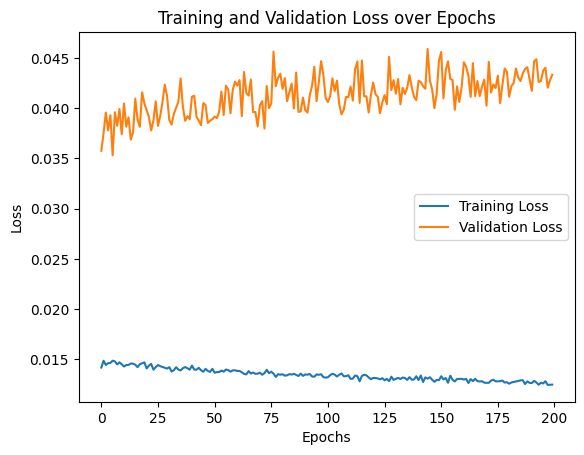

In [67]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# K nn implementation

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
X_train_embeddings = tf_embedding_model.predict(x_train)
X_test_embeddings = tf_embedding_model.predict(x_test)

# Step 2: Initialize and train the KNN model on embeddings
knn = KNeighborsClassifier(n_neighbors=5 ,weights='uniform')  # You can adjust the number of neighbors
knn.fit(X_train_embeddings, y_train)

# Step 3: Make predictions on test embeddings
y_pred = knn.predict(X_test_embeddings)

# Optional: Evaluate the model
accuracy = knn.score(X_test_embeddings, y_test)
accuracy2 = knn.score(X_train_embeddings, y_train)
print("Accuracy Test Data:", accuracy)
print("Accuracy Train Data:", accuracy2)

2464/2464 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy Test Data: 0.3417047184170472
Accuracy Train Data: 0.5364282090309488


In [70]:
from sklearn.metrics import classification_report

# y_train_pred= knn.predict(X_train_embeddings)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.30      0.20       340
           1       0.24      0.42      0.30       510
           2       0.16      0.25      0.19       310
           3       0.40      0.63      0.49       340
           4       0.25      0.42      0.31       650
           5       0.21      0.31      0.25       510
           6       0.30      0.30      0.30       320
           7       0.33      0.38      0.35       450
           8       0.30      0.33      0.31       400
           9       0.42      0.54      0.47       480
          10       0.31      0.33      0.32       420
          11       0.43      0.63      0.51       720
          12       0.44      0.42      0.43       540
          13       0.50      0.54      0.52       470
          14       0.32      0.29      0.31       340
          15       0.32      0.43      0.37       550
          16       0.27      0.11      0.16       340
          17       0.29    

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Step 2: Initialize and train the XGBoost model on embeddings
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, objective='multi:softmax', num_class=no_speakers_file)  # Adjust parameters as needed
xgb_model.fit(X_train_embeddings, y_train)

# Step 3: Make predictions on test embeddings
y_pred = xgb_model.predict(X_test_embeddings)

# Optional: Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, xgb_model.predict(X_train_embeddings))
print("Accuracy Test Data:", accuracy_test)
print("Accuracy Train Data:", accuracy_train)